<a href="https://colab.research.google.com/github/ioana0901/Sentiment-Analysis-on-Short-Texts-The-Case-of-the-Romanian-Language/blob/main/Pretrained_Word2Vec_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install gensim==3.0.0
#!pip install -U gensim
#then restart runtime, otherwise the loading of word2vec model won't work

In [ ]:
!pip install import_ipynb

from google.colab import drive
drive.mount('/content/drive')

In [1]:
%cd "/content/drive/MyDrive/Analiza sentimentelor umane a textelor din Limba Română"

/content/drive/MyDrive/Analiza sentimentelor umane a textelor din Limba Română


In [2]:
import import_ipynb
from FunctionsList import *
import pandas as pd
import numpy as np
import random
import gensim
import joblib 
import seaborn as sns

from gensim.models import KeyedVectors, Word2Vec
from tensorflow.keras.utils import to_categorical

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras import regularizers, callbacks
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Embedding, Flatten, Dense, LSTM, GRU, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Bidirectional, Dropout
from keras.regularizers import l2

importing Jupyter notebook from FunctionsList.ipynb


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
#import data:
data = pd.read_csv('Data/CleanDataset_for_PretrainedWord2Vec.csv')
#sterge prima coloana
data = data.iloc[: , 1:]
data.head()

,label,review_content
0,2,Tine bateria lejer zi intreaga cu decenta din...
1,2,Telefonul ofera foarte mult pentru pretul sau ...
2,0,Dupa doua luni deja merge ca un tractor acei ...
3,2,Despre livrare a fost ok a ajuns exact in timp...
4,2,Scriu acest review la luni de la achizitie si...


### Impartirea setului de date

In [4]:
# imparte setul de date: 80% - 20% 
contents = data['review_content']
labels = data['label']
x_train, x_test, y_train, y_test = train_test_split(contents, labels, train_size=0.8, random_state=42)

### Vectorizare

In [5]:
# Transformarea cuvintelor in float
tokenizer = Tokenizer(num_words = 9000) #maxim 9000 cele mai comune cuvinte

# crearea vocabularului
tokenizer.fit_on_texts(x_train)
# numarul de cuvinte unice
unique_words = tokenizer.word_index

# converteste textul in float pentru x
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

#sunt 30326 tokeni unici
print('%s unique tokens' % len(unique_words))

30326 unique tokens


In [6]:
# identifica lungimea maxima a recenziilor
maxlen = 0
for rev_n in range(len(x_train)):
    n = len(x_train[rev_n])
    if n > maxlen:
        maxlen = n
print(maxlen)

2051


In [7]:
# de vreme ce unele recenzii au o lungime mai mica decat lungimea maxima calculata mai sus (2051)
# - ele trebuie aduse la aceeasi lungime pentru a avea acelasi shape
# padding pentru ambele seturi
x_train = pad_sequences(x_train, maxlen=maxlen) #pad sequences so they have same length
x_test = pad_sequences(x_test, maxlen=maxlen)

print("x_train.shape:", x_train.shape)
print("x_test.shape :", x_test.shape)

x_train.shape: (12900, 2051)
x_test.shape : (3225, 2051)


In [8]:
#one-hot encode labels
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)
print("y_train.shape:", y_train.shape)
print("y_test.shape :", y_test.shape)

y_train.shape: (12900, 3)
y_test.shape : (3225, 3)


### Incarcarea modelului Word2vec - Crearea stratului de embedding 

In [ ]:
'''
100 de dimensiuni și peste 241 mii de cuvinte 
a fost antrenat pe un corp de date în limba română - wiki_2019_ro folosind varianta CBOW
-de remarcat faptul că în antrenarea acestui model nu s-au preprocesat textele, fapt pentru care, în acest caz, 
setul de date a fost curățat doar de tag-urile HTML, numere, caracterele extra din cuvinte și punctuație.
'''

'\n100 de dimensiuni și peste 241 mii de cuvinte \na fost antrenat pe un corp de date în limba română - wiki_2019_ro folosind varianta CBOW\n-de remarcat faptul că în antrenarea acestui model nu s-au preprocesat textele, fapt pentru care, în acest caz, \nsetul de date a fost curățat doar de tag-urile HTML, numere, caracterele extra din cuvinte și punctuație.\n'

In [9]:
#load word embedding model 
word2vec_model = KeyedVectors.load('Word2Vec_Trained_Model/word2vec-ro-100-cbow-negative_sampling.model')
# see vector size is =100 and nr of words =30326

In [10]:
word2vec_model.wv.most_similar('bun')

[('promițător', 0.7119244337081909),
 ('scump', 0.6952224969863892),
 ('profitabil', 0.6877985000610352),
 ('longeviv', 0.6870125532150269),
 ('îndrăzneț', 0.6790050864219666),
 ('prestigios', 0.6746405363082886),
 ('vârstnic', 0.6681191921234131),
 ('titrat', 0.6666390895843506),
 ('tânăr', 0.656938910484314),
 ('notabil', 0.632922351360321)]

In [11]:
# modelul are 100 de dimensiune -> fiecare cuvant are 100 dim si peste 30000 de cuvinte
# de vreme ce suntem interesati doar de cele 15120 cuvinte din setul de train -> cream matricea de embedding de forma (30326+1, 100)
total_words = len(unique_words) + 1
skipped_words = 0 
l=[] #vezi skipped words daca exista
embedding_dim = 100
embedding_matrix = np.zeros((total_words, embedding_dim)) #forma matricei 

for word, i in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[i] = word2vec_model.wv.__getitem__(word)
    else:
        skipped_words = skipped_words + 1
        l.append(word)
        
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (30327, 100)


In [12]:
#Crearea stratului de embedding
embedding_layer = Embedding(total_words, 
                            embedding_dim,
                            weights = [embedding_matrix],
                            input_length = maxlen, 
                            trainable = False)

## Crearea si antrenarea de modele

In [13]:
import random
random.seed(42)

### LSTM

In [ ]:
# definirea modelului-------------8------------------
from keras.models import Sequential

lstm_model = Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(8))
lstm_model.add(Dense(3, activation = 'softmax'))

lstm_model.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = lstm_model.fit(x_train, 
                         y_train,
                         epochs=10,
                         batch_size=64,
                         validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 126s 719ms/step - loss: 1.0895 - acc: 0.3945 - val_loss: 1.0556 - val_acc: 0.4496
Epoch 2/10
172/172 [==============================] - 121s 706ms/step - loss: 0.9847 - acc: 0.5373 - val_loss: 0.9106 - val_acc: 0.5845
Epoch 3/10
172/172 [==============================] - 122s 709ms/step - loss: 0.8861 - acc: 0.5915 - val_loss: 0.8633 - val_acc: 0.6052
Epoch 4/10
172/172 [==============================] - 119s 695ms/step - loss: 0.8445 - acc: 0.6150 - val_loss: 0.8294 - val_acc: 0.6274
Epoch 5/10
172/172 [==============================] - 119s 693ms/step - loss: 0.8157 - acc: 0.6343 - val_loss: 0.8158 - val_acc: 0.6320
Epoch 6/10
172/172 [==============================] - 120s 697ms/step - loss: 0.7917 - acc: 0.6471 - val_loss: 0.8112 - val_acc: 0.6310
Epoch 7/10
172/172 [==============================] - 119s 694ms/step - loss: 0.7737 - acc: 0.6586 - val_loss: 0.7988 - val_acc: 0.6382
Epoch 8/10
172/172 [============================

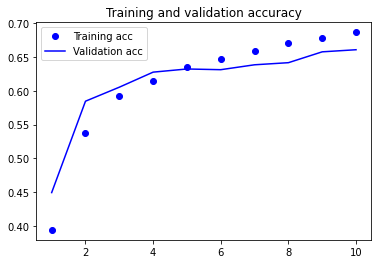

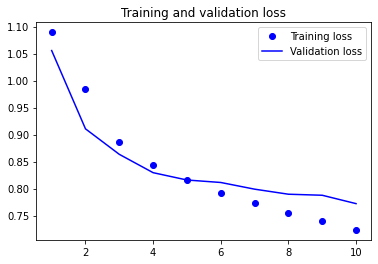

In [ ]:
plot_graphs(history)

In [ ]:
lstm_model.evaluate(x_test, y_test)

101/101 [==============================] - 13s 130ms/step - loss: 0.7784 - acc: 0.6629


[0.7784168124198914, 0.6629457473754883]

In [ ]:
pred=lstm_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 13s 126ms/step
              precision    recall  f1-score   support

         neg       0.59      0.69      0.64       918
           n       0.54      0.69      0.60       822
         pos       0.86      0.64      0.73      1485

    accuracy                           0.66      3225
   macro avg       0.66      0.67      0.66      3225
weighted avg       0.70      0.66      0.67      3225



In [ ]:
# definirea modelului------------16--------------
lstm_model2 = Sequential()
lstm_model2.add(embedding_layer)
lstm_model2.add(LSTM(16))
lstm_model2.add(Dense(3, activation = 'softmax'))

lstm_model2.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = lstm_model2.fit(x_train, 
                         y_train,
                         epochs=10,
                         batch_size=64,
                         validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 138s 783ms/step - loss: 1.0763 - acc: 0.4111 - val_loss: 1.0442 - val_acc: 0.4517
Epoch 2/10
172/172 [==============================] - 135s 785ms/step - loss: 0.9753 - acc: 0.5187 - val_loss: 0.8969 - val_acc: 0.5674
Epoch 3/10
172/172 [==============================] - 132s 767ms/step - loss: 0.8375 - acc: 0.6118 - val_loss: 0.8468 - val_acc: 0.5917
Epoch 4/10
172/172 [==============================] - 135s 786ms/step - loss: 0.7868 - acc: 0.6386 - val_loss: 0.8166 - val_acc: 0.6186
Epoch 5/10
172/172 [==============================] - 135s 783ms/step - loss: 0.7546 - acc: 0.6604 - val_loss: 0.8107 - val_acc: 0.6191
Epoch 6/10
172/172 [==============================] - 133s 776ms/step - loss: 0.7273 - acc: 0.6782 - val_loss: 0.7870 - val_acc: 0.6424
Epoch 7/10
172/172 [==============================] - 134s 777ms/step - loss: 0.7042 - acc: 0.6920 - val_loss: 0.7789 - val_acc: 0.6465
Epoch 8/10
172/172 [============================

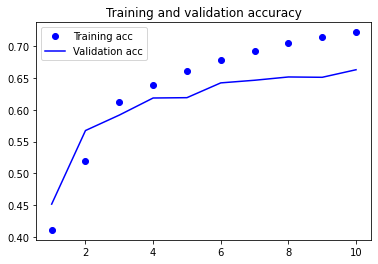

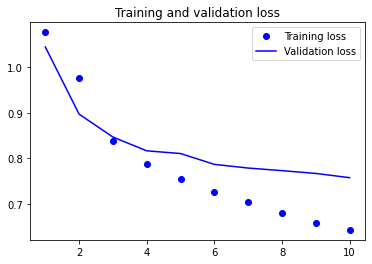

In [ ]:
plot_graphs(history)

In [ ]:
lstm_model2.evaluate(x_test, y_test)

101/101 [==============================] - 20s 197ms/step - loss: 0.7547 - acc: 0.6651


[0.7546588778495789, 0.6651162505149841]

In [ ]:
pred=lstm_model2.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 19s 181ms/step
              precision    recall  f1-score   support

         neg       0.66      0.65      0.65      1096
           n       0.56      0.67      0.61       881
         pos       0.77      0.68      0.72      1248

    accuracy                           0.67      3225
   macro avg       0.66      0.66      0.66      3225
weighted avg       0.68      0.67      0.67      3225



In [ ]:
# definirea modelului------------32--------------
lstm_model3 = Sequential()
lstm_model3.add(embedding_layer)
lstm_model3.add(LSTM(32))
lstm_model3.add(Dense(3, activation = 'softmax'))

lstm_model3.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = lstm_model3.fit(x_train, 
                         y_train,
                         epochs=10,
                         batch_size=64,
                         validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 167s 957ms/step - loss: 1.0045 - acc: 0.4872 - val_loss: 0.8641 - val_acc: 0.5928
Epoch 2/10
172/172 [==============================] - 161s 934ms/step - loss: 0.8230 - acc: 0.6171 - val_loss: 0.8178 - val_acc: 0.6114
Epoch 3/10
172/172 [==============================] - 161s 936ms/step - loss: 0.7687 - acc: 0.6495 - val_loss: 0.7912 - val_acc: 0.6264
Epoch 4/10
172/172 [==============================] - 161s 939ms/step - loss: 0.7330 - acc: 0.6741 - val_loss: 0.8034 - val_acc: 0.6439
Epoch 5/10
172/172 [==============================] - 162s 943ms/step - loss: 0.6998 - acc: 0.6879 - val_loss: 0.7893 - val_acc: 0.6320
Epoch 6/10
172/172 [==============================] - 162s 940ms/step - loss: 0.6634 - acc: 0.7099 - val_loss: 0.7669 - val_acc: 0.6496
Epoch 7/10
172/172 [==============================] - 163s 946ms/step - loss: 0.6385 - acc: 0.7220 - val_loss: 0.7565 - val_acc: 0.6682
Epoch 8/10
172/172 [============================

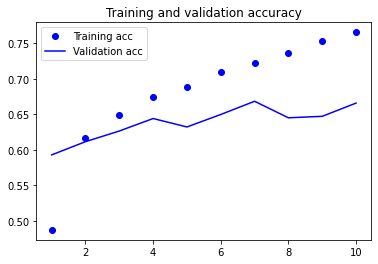

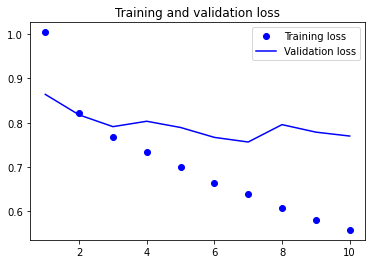

In [ ]:
plot_graphs(history)

In [ ]:
lstm_model3.evaluate(x_test, y_test)

101/101 [==============================] - 24s 233ms/step - loss: 0.7530 - acc: 0.6639


[0.7530330419540405, 0.6638759970664978]

In [ ]:
pred=lstm_model3.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 25s 241ms/step
              precision    recall  f1-score   support

         neg       0.73      0.61      0.67      1285
           n       0.48      0.75      0.59       685
         pos       0.77      0.67      0.72      1255

    accuracy                           0.66      3225
   macro avg       0.66      0.68      0.66      3225
weighted avg       0.69      0.66      0.67      3225



In [ ]:
# definirea modelului------------64--------------
lstm_model4 = Sequential()
lstm_model4.add(embedding_layer)
lstm_model4.add(LSTM(64))
lstm_model4.add(Dense(3, activation = 'softmax'))

lstm_model4.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = lstm_model4.fit(x_train, 
                         y_train,
                         epochs=10,
                         batch_size=64,
                         validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 333s 2s/step - loss: 0.9487 - acc: 0.5216 - val_loss: 0.8118 - val_acc: 0.6134
Epoch 2/10
172/172 [==============================] - 331s 2s/step - loss: 0.7775 - acc: 0.6472 - val_loss: 0.7611 - val_acc: 0.6651
Epoch 3/10
172/172 [==============================] - 328s 2s/step - loss: 0.7145 - acc: 0.6839 - val_loss: 0.7532 - val_acc: 0.6553
Epoch 4/10
172/172 [==============================] - 328s 2s/step - loss: 0.6588 - acc: 0.7124 - val_loss: 0.7292 - val_acc: 0.6879
Epoch 5/10
172/172 [==============================] - 340s 2s/step - loss: 0.6161 - acc: 0.7340 - val_loss: 0.7185 - val_acc: 0.6889
Epoch 6/10
172/172 [==============================] - 333s 2s/step - loss: 0.5756 - acc: 0.7544 - val_loss: 0.7790 - val_acc: 0.6460
Epoch 7/10
172/172 [==============================] - 333s 2s/step - loss: 0.5313 - acc: 0.7787 - val_loss: 0.7097 - val_acc: 0.6904
Epoch 8/10
172/172 [==============================] - 332s 2s/step - 

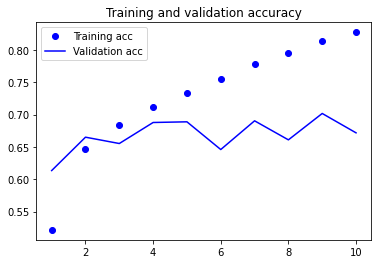

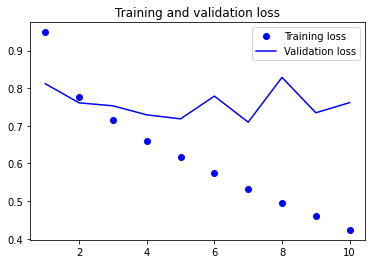

In [ ]:
plot_graphs(history)

In [ ]:
lstm_model4.evaluate(x_test, y_test)

101/101 [==============================] - 29s 285ms/step - loss: 0.7561 - acc: 0.6716


[0.7561180591583252, 0.6716278791427612]

In [ ]:
pred=lstm_model4.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 29s 283ms/step
              precision    recall  f1-score   support

         neg       0.67      0.71      0.69      1013
           n       0.61      0.61      0.61      1066
         pos       0.73      0.70      0.71      1146

    accuracy                           0.67      3225
   macro avg       0.67      0.67      0.67      3225
weighted avg       0.67      0.67      0.67      3225



In [ ]:
# definirea modelului------------128--------------
lstm_model5 = Sequential()
lstm_model5.add(embedding_layer)
lstm_model5.add(LSTM(128))
lstm_model5.add(Dense(3, activation = 'softmax'))

lstm_model5.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = lstm_model5.fit(x_train, 
                         y_train,
                         epochs=10,
                         batch_size=64,
                         validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 754s 4s/step - loss: 0.8946 - acc: 0.5531 - val_loss: 1.0020 - val_acc: 0.4935
Epoch 2/10
172/172 [==============================] - 745s 4s/step - loss: 0.7534 - acc: 0.6575 - val_loss: 0.7482 - val_acc: 0.6532
Epoch 3/10
172/172 [==============================] - 739s 4s/step - loss: 0.6817 - acc: 0.6944 - val_loss: 0.7617 - val_acc: 0.6610
Epoch 4/10
172/172 [==============================] - 739s 4s/step - loss: 0.6246 - acc: 0.7286 - val_loss: 0.8402 - val_acc: 0.6553
Epoch 5/10
172/172 [==============================] - 733s 4s/step - loss: 0.5668 - acc: 0.7600 - val_loss: 0.7119 - val_acc: 0.6822
Epoch 6/10
172/172 [==============================] - 737s 4s/step - loss: 0.5035 - acc: 0.7916 - val_loss: 0.7591 - val_acc: 0.6879
Epoch 7/10
172/172 [==============================] - 736s 4s/step - loss: 0.4442 - acc: 0.8207 - val_loss: 0.7595 - val_acc: 0.6708
Epoch 8/10
172/172 [==============================] - 733s 4s/step - 

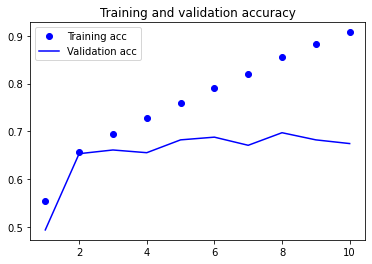

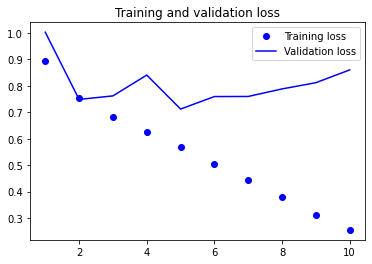

In [ ]:
plot_graphs(history)

In [ ]:
lstm_model5.evaluate(x_test, y_test)

101/101 [==============================] - 102s 1s/step - loss: 0.8422 - acc: 0.6819


[0.8422372341156006, 0.6818604469299316]

In [ ]:
pred=lstm_model5.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 99s 976ms/step
              precision    recall  f1-score   support

         neg       0.69      0.67      0.68      1107
           n       0.62      0.64      0.63      1021
         pos       0.73      0.74      0.73      1097

    accuracy                           0.68      3225
   macro avg       0.68      0.68      0.68      3225
weighted avg       0.68      0.68      0.68      3225



In [ ]:
# definirea modelului------------256--------------
lstm_model6 = Sequential()
lstm_model6.add(embedding_layer)
lstm_model6.add(LSTM(256))
lstm_model6.add(Dense(3, activation = 'softmax'))

lstm_model6.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = lstm_model6.fit(x_train, 
                         y_train,
                         epochs=10,
                         batch_size=64,
                         validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 1807s 10s/step - loss: 0.9112 - acc: 0.5496 - val_loss: 0.8081 - val_acc: 0.6010
Epoch 2/10
172/172 [==============================] - 1813s 11s/step - loss: 0.7809 - acc: 0.6389 - val_loss: 0.7854 - val_acc: 0.6279
Epoch 3/10
172/172 [==============================] - 1808s 11s/step - loss: 0.6810 - acc: 0.6969 - val_loss: 0.7225 - val_acc: 0.6698
Epoch 4/10
172/172 [==============================] - 1790s 10s/step - loss: 0.6028 - acc: 0.7381 - val_loss: 0.7059 - val_acc: 0.6889
Epoch 5/10
172/172 [==============================] - 1785s 10s/step - loss: 0.5146 - acc: 0.7863 - val_loss: 0.7818 - val_acc: 0.6770
Epoch 6/10
172/172 [==============================] - 1790s 10s/step - loss: 0.4113 - acc: 0.8375 - val_loss: 0.8811 - val_acc: 0.6171
Epoch 7/10
172/172 [==============================] - 1769s 10s/step - loss: 0.3082 - acc: 0.8853 - val_loss: 0.8911 - val_acc: 0.6424
Epoch 8/10
172/172 [==============================] - 1

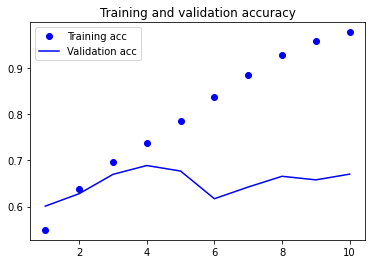

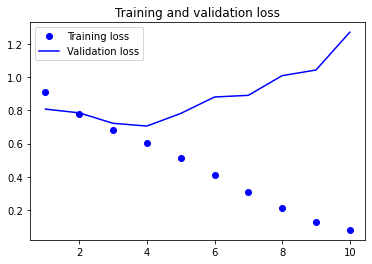

In [ ]:
plot_graphs(history)

In [ ]:
lstm_model6.evaluate(x_test, y_test)

101/101 [==============================] - 212s 2s/step - loss: 1.2559 - acc: 0.6704


[1.2558947801589966, 0.6703876256942749]

In [ ]:
pred=lstm_model6.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 229s 2s/step
              precision    recall  f1-score   support

         neg       0.54      0.76      0.63       751
           n       0.62      0.63      0.62      1044
         pos       0.85      0.66      0.74      1430

    accuracy                           0.67      3225
   macro avg       0.67      0.68      0.66      3225
weighted avg       0.70      0.67      0.68      3225



In [ ]:
#because it takes a longer time to train the model, i used CudnnLSTM instead of LSTM

In [15]:
# ------512--------------
from keras.layers import CuDNNLSTM, CuDNNGRU
lstm_model = Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(CuDNNLSTM(512))
lstm_model.add(Dense(3, activation = 'softmax'))

lstm_model.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = lstm_model.fit(x_train, 
                         y_train,
                         epochs=10,
                         batch_size=64,
                         validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 95s 394ms/step - loss: 0.9242 - acc: 0.5536 - val_loss: 0.9708 - val_acc: 0.5194
Epoch 2/10
172/172 [==============================] - 70s 407ms/step - loss: 0.7687 - acc: 0.6470 - val_loss: 0.7766 - val_acc: 0.6481
Epoch 3/10
172/172 [==============================] - 70s 407ms/step - loss: 0.6797 - acc: 0.6979 - val_loss: 0.7801 - val_acc: 0.6506
Epoch 4/10
172/172 [==============================] - 70s 407ms/step - loss: 0.5774 - acc: 0.7483 - val_loss: 0.7527 - val_acc: 0.6739
Epoch 5/10
172/172 [==============================] - 70s 407ms/step - loss: 0.4448 - acc: 0.8203 - val_loss: 0.7998 - val_acc: 0.6646
Epoch 6/10
172/172 [==============================] - 70s 407ms/step - loss: 0.3018 - acc: 0.8883 - val_loss: 0.9452 - val_acc: 0.6310
Epoch 7/10
172/172 [==============================] - 70s 407ms/step - loss: 0.1688 - acc: 0.9424 - val_loss: 1.0877 - val_acc: 0.6470
Epoch 8/10
172/172 [==============================] - 7

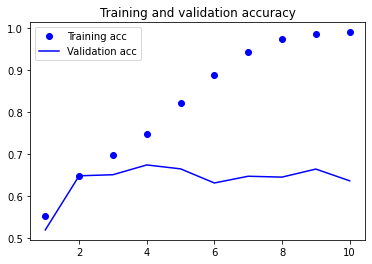

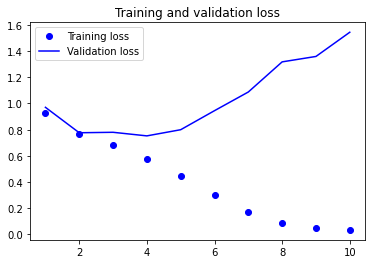

In [16]:
plot_graphs(history)

In [17]:
lstm_model.evaluate(x_test, y_test)

101/101 [==============================] - 11s 101ms/step - loss: 1.4783 - acc: 0.6465


[1.478334903717041, 0.6465116143226624]

In [18]:
pred=lstm_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 9s 88ms/step
              precision    recall  f1-score   support

         neg       0.66      0.70      0.68      1008
           n       0.65      0.56      0.60      1215
         pos       0.64      0.70      0.67      1002

    accuracy                           0.65      3225
   macro avg       0.65      0.65      0.65      3225
weighted avg       0.65      0.65      0.64      3225



In [21]:
# ----128--0.2--64----0.2------
lstm_model = Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(CuDNNLSTM(128,return_sequences = True))
lstm_model.add(Dropout(0.2))
lstm_model.add(CuDNNLSTM(64))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(3, activation = 'softmax'))

lstm_model.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = lstm_model.fit(x_train, 
                         y_train,
                         epochs=10,
                         batch_size=64,
                         validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 39s 209ms/step - loss: 0.8803 - acc: 0.5711 - val_loss: 0.8068 - val_acc: 0.6119
Epoch 2/10
172/172 [==============================] - 30s 175ms/step - loss: 0.7640 - acc: 0.6558 - val_loss: 0.7557 - val_acc: 0.6636
Epoch 3/10
172/172 [==============================] - 29s 170ms/step - loss: 0.7059 - acc: 0.6932 - val_loss: 0.9051 - val_acc: 0.6181
Epoch 4/10
172/172 [==============================] - 31s 180ms/step - loss: 0.6518 - acc: 0.7208 - val_loss: 0.7445 - val_acc: 0.6889
Epoch 5/10
172/172 [==============================] - 30s 174ms/step - loss: 0.5974 - acc: 0.7447 - val_loss: 0.8436 - val_acc: 0.6372
Epoch 6/10
172/172 [==============================] - 29s 172ms/step - loss: 0.5404 - acc: 0.7691 - val_loss: 1.1315 - val_acc: 0.6098
Epoch 7/10
172/172 [==============================] - 29s 169ms/step - loss: 0.4843 - acc: 0.8037 - val_loss: 0.8301 - val_acc: 0.6832
Epoch 8/10
172/172 [==============================] - 2

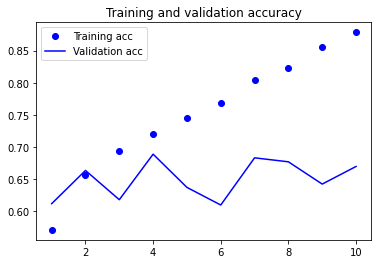

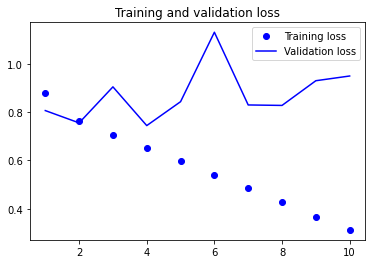

In [22]:
plot_graphs(history)

In [23]:
lstm_model.evaluate(x_test, y_test)

101/101 [==============================] - 10s 91ms/step - loss: 0.8799 - acc: 0.6902


[0.879868745803833, 0.6902325749397278]

In [24]:
pred=lstm_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 12s 112ms/step
              precision    recall  f1-score   support

         neg       0.74      0.66      0.70      1195
           n       0.56      0.68      0.61       873
         pos       0.76      0.73      0.75      1157

    accuracy                           0.69      3225
   macro avg       0.69      0.69      0.69      3225
weighted avg       0.70      0.69      0.69      3225



In [25]:
# ----128--0.4--64----0.4------
lstm_model = Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(CuDNNLSTM(128,return_sequences = True))
lstm_model.add(Dropout(0.4))
lstm_model.add(CuDNNLSTM(64))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(3, activation = 'softmax'))

lstm_model.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = lstm_model.fit(x_train, 
                         y_train,
                         epochs=10,
                         batch_size=64,
                         validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 40s 222ms/step - loss: 0.8893 - acc: 0.5635 - val_loss: 0.8304 - val_acc: 0.6196
Epoch 2/10
172/172 [==============================] - 30s 175ms/step - loss: 0.7760 - acc: 0.6479 - val_loss: 0.7742 - val_acc: 0.6594
Epoch 3/10
172/172 [==============================] - 30s 173ms/step - loss: 0.7232 - acc: 0.6803 - val_loss: 0.7329 - val_acc: 0.6811
Epoch 4/10
172/172 [==============================] - 30s 175ms/step - loss: 0.6717 - acc: 0.7068 - val_loss: 0.7959 - val_acc: 0.6558
Epoch 5/10
172/172 [==============================] - 32s 183ms/step - loss: 0.6307 - acc: 0.7340 - val_loss: 0.7378 - val_acc: 0.6863
Epoch 6/10
172/172 [==============================] - 30s 175ms/step - loss: 0.5895 - acc: 0.7507 - val_loss: 0.7537 - val_acc: 0.6904
Epoch 7/10
172/172 [==============================] - 30s 172ms/step - loss: 0.5341 - acc: 0.7765 - val_loss: 0.7909 - val_acc: 0.6615
Epoch 8/10
172/172 [==============================] - 3

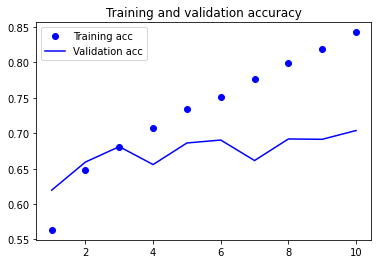

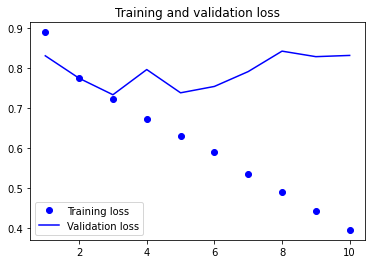

In [26]:
plot_graphs(history)

In [27]:
lstm_model.evaluate(x_test, y_test)

101/101 [==============================] - 7s 68ms/step - loss: 0.8111 - acc: 0.7054


[0.8111071586608887, 0.7054263353347778]

In [28]:
pred=lstm_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 7s 65ms/step
              precision    recall  f1-score   support

         neg       0.71      0.71      0.71      1075
           n       0.56      0.71      0.63       834
         pos       0.83      0.70      0.76      1316

    accuracy                           0.71      3225
   macro avg       0.70      0.71      0.70      3225
weighted avg       0.72      0.71      0.71      3225



In [34]:
# ----128--0.4--64--0.4----
from keras.optimizers import Adam
lstm_model = Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(CuDNNLSTM(128,return_sequences = True))
lstm_model.add(Dropout(0.4))
lstm_model.add(CuDNNLSTM(64))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(3, activation = 'softmax'))

lstm_model.compile(optimizer= Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = lstm_model.fit(x_train, 
                         y_train,
                         epochs=15,
                         batch_size=64,
                         validation_split=0.15)

Epoch 1/15
172/172 [==============================] - 31s 172ms/step - loss: 1.0766 - acc: 0.4190 - val_loss: 1.0340 - val_acc: 0.4972
Epoch 2/15
172/172 [==============================] - 29s 169ms/step - loss: 0.9497 - acc: 0.5405 - val_loss: 0.8327 - val_acc: 0.5969
Epoch 3/15
172/172 [==============================] - 32s 186ms/step - loss: 0.8352 - acc: 0.6113 - val_loss: 0.8096 - val_acc: 0.6186
Epoch 4/15
172/172 [==============================] - 31s 179ms/step - loss: 0.8023 - acc: 0.6313 - val_loss: 0.8090 - val_acc: 0.6258
Epoch 5/15
172/172 [==============================] - 30s 172ms/step - loss: 0.7765 - acc: 0.6476 - val_loss: 0.7768 - val_acc: 0.6527
Epoch 6/15
172/172 [==============================] - 30s 172ms/step - loss: 0.7548 - acc: 0.6627 - val_loss: 0.7694 - val_acc: 0.6589
Epoch 7/15
172/172 [==============================] - 30s 173ms/step - loss: 0.7327 - acc: 0.6738 - val_loss: 0.7509 - val_acc: 0.6651
Epoch 8/15
172/172 [==============================] - 3

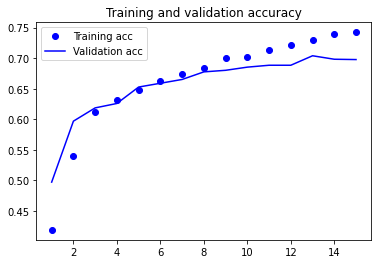

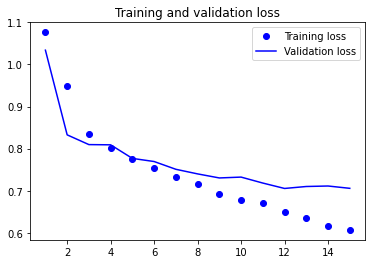

In [35]:
plot_graphs(history)

In [36]:
lstm_model.evaluate(x_test, y_test)

101/101 [==============================] - 7s 69ms/step - loss: 0.7174 - acc: 0.6986


[0.7173522114753723, 0.6986046433448792]

In [37]:
pred=lstm_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 8s 74ms/step
              precision    recall  f1-score   support

         neg       0.66      0.70      0.68      1017
           n       0.58      0.72      0.64       850
         pos       0.84      0.69      0.76      1358

    accuracy                           0.70      3225
   macro avg       0.70      0.70      0.69      3225
weighted avg       0.72      0.70      0.70      3225



### GRU

In [ ]:
# definirea modelului ------------------8------------------
gru_model1 = Sequential()
gru_model1.add(embedding_layer)
gru_model1.add(GRU(8))
gru_model1.add(Dense(3, activation = 'softmax'))

gru_model1.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
history = gru_model1.fit(x_train,
                        y_train,
                        epochs=10,
                        batch_size=64,
                        validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 143s 806ms/step - loss: 1.1114 - acc: 0.4101 - val_loss: 1.0845 - val_acc: 0.4222
Epoch 2/10
172/172 [==============================] - 136s 791ms/step - loss: 1.0581 - acc: 0.4522 - val_loss: 1.0552 - val_acc: 0.4568
Epoch 3/10
172/172 [==============================] - 127s 737ms/step - loss: 1.0248 - acc: 0.4782 - val_loss: 1.0176 - val_acc: 0.5028
Epoch 4/10
172/172 [==============================] - 125s 725ms/step - loss: 0.9660 - acc: 0.5312 - val_loss: 0.9321 - val_acc: 0.5612
Epoch 5/10
172/172 [==============================] - 127s 738ms/step - loss: 0.8914 - acc: 0.5800 - val_loss: 0.8846 - val_acc: 0.5788
Epoch 6/10
172/172 [==============================] - 126s 732ms/step - loss: 0.8512 - acc: 0.6012 - val_loss: 0.8564 - val_acc: 0.6000
Epoch 7/10
172/172 [==============================] - 125s 726ms/step - loss: 0.8249 - acc: 0.6203 - val_loss: 0.8423 - val_acc: 0.6150
Epoch 8/10
172/172 [============================

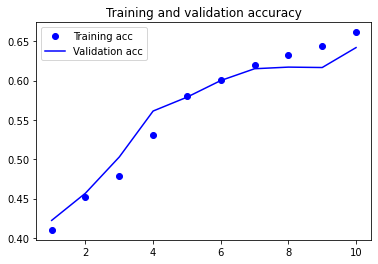

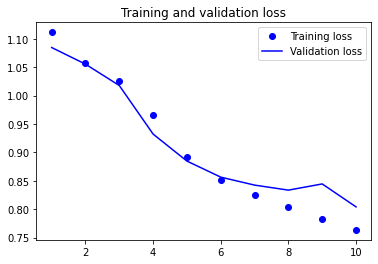

In [ ]:
plot_graphs(history)

In [ ]:
gru_model1.evaluate(x_test, y_test)

101/101 [==============================] - 15s 150ms/step - loss: 0.7878 - acc: 0.6546


[0.787803053855896, 0.6545736193656921]

In [ ]:
pred=gru_model1.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 26s 249ms/step
              precision    recall  f1-score   support

         neg       0.61      0.64      0.63      1021
           n       0.49      0.71      0.58       726
         pos       0.86      0.64      0.73      1478

    accuracy                           0.65      3225
   macro avg       0.65      0.66      0.64      3225
weighted avg       0.70      0.65      0.66      3225



In [ ]:
# definirea modelului ------------------16------------------
gru_model2 = Sequential()
gru_model2.add(embedding_layer)
gru_model2.add(GRU(16))
gru_model2.add(Dense(3, activation = 'softmax'))

gru_model2.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
history = gru_model2.fit(x_train,
                        y_train,
                        epochs=10,
                        batch_size=64,
                        validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 153s 868ms/step - loss: 1.1111 - acc: 0.4110 - val_loss: 1.0636 - val_acc: 0.4403
Epoch 2/10
172/172 [==============================] - 146s 848ms/step - loss: 1.0141 - acc: 0.4885 - val_loss: 1.0013 - val_acc: 0.5039
Epoch 3/10
172/172 [==============================] - 146s 847ms/step - loss: 0.9221 - acc: 0.5652 - val_loss: 0.9011 - val_acc: 0.5747
Epoch 4/10
172/172 [==============================] - 143s 832ms/step - loss: 0.8422 - acc: 0.6109 - val_loss: 0.8563 - val_acc: 0.5902
Epoch 5/10
172/172 [==============================] - 143s 830ms/step - loss: 0.7994 - acc: 0.6345 - val_loss: 0.8276 - val_acc: 0.6129
Epoch 6/10
172/172 [==============================] - 143s 831ms/step - loss: 0.7680 - acc: 0.6542 - val_loss: 0.8116 - val_acc: 0.6243
Epoch 7/10
172/172 [==============================] - 143s 833ms/step - loss: 0.7450 - acc: 0.6658 - val_loss: 0.8011 - val_acc: 0.6284
Epoch 8/10
172/172 [============================

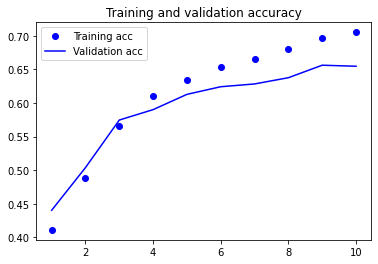

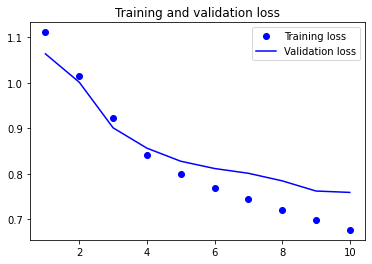

In [ ]:
plot_graphs(history)

In [ ]:
gru_model2.evaluate(x_test, y_test)

101/101 [==============================] - 21s 211ms/step - loss: 0.7472 - acc: 0.6667


[0.7472051382064819, 0.6666666865348816]

In [ ]:
pred=gru_model2.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 15s 142ms/step
              precision    recall  f1-score   support

         neg       0.69      0.64      0.66      1165
           n       0.52      0.70      0.60       782
         pos       0.78      0.67      0.72      1278

    accuracy                           0.67      3225
   macro avg       0.66      0.67      0.66      3225
weighted avg       0.69      0.67      0.67      3225



In [ ]:
# definirea modelului ------------------32------------------
gru_model3 = Sequential()
gru_model3.add(embedding_layer)
gru_model3.add(GRU(32))
gru_model3.add(Dense(3, activation = 'softmax'))

gru_model3.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
history = gru_model3.fit(x_train,
                        y_train,
                        epochs=10,
                        batch_size=64,
                        validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 174s 996ms/step - loss: 1.0846 - acc: 0.4212 - val_loss: 1.0319 - val_acc: 0.4749
Epoch 2/10
172/172 [==============================] - 169s 980ms/step - loss: 0.9725 - acc: 0.5256 - val_loss: 0.9251 - val_acc: 0.5674
Epoch 3/10
172/172 [==============================] - 170s 988ms/step - loss: 0.8282 - acc: 0.6206 - val_loss: 0.8336 - val_acc: 0.6129
Epoch 4/10
172/172 [==============================] - 169s 983ms/step - loss: 0.7575 - acc: 0.6592 - val_loss: 0.7982 - val_acc: 0.6367
Epoch 5/10
172/172 [==============================] - 172s 1s/step - loss: 0.7120 - acc: 0.6824 - val_loss: 0.7775 - val_acc: 0.6527
Epoch 6/10
172/172 [==============================] - 168s 975ms/step - loss: 0.6763 - acc: 0.7056 - val_loss: 0.7513 - val_acc: 0.6677
Epoch 7/10
172/172 [==============================] - 172s 1s/step - loss: 0.6466 - acc: 0.7209 - val_loss: 0.7449 - val_acc: 0.6636
Epoch 8/10
172/172 [==============================] - 

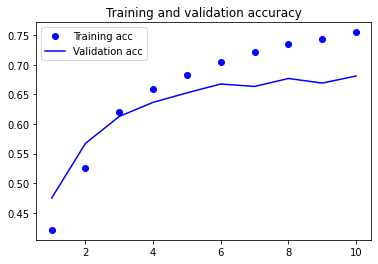

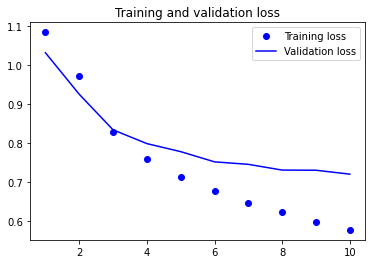

In [ ]:
plot_graphs(history)

In [ ]:
gru_model3.evaluate(x_test, y_test)

101/101 [==============================] - 16s 160ms/step - loss: 0.7179 - acc: 0.6831


[0.7178821563720703, 0.6831007599830627]

In [ ]:
pred=gru_model3.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 16s 159ms/step
              precision    recall  f1-score   support

         neg       0.73      0.65      0.69      1194
           n       0.51      0.73      0.60       741
         pos       0.80      0.68      0.74      1290

    accuracy                           0.68      3225
   macro avg       0.68      0.69      0.68      3225
weighted avg       0.71      0.68      0.69      3225



In [ ]:
# definirea modelului ------------------64------------------
gru_model4 = Sequential()
gru_model4.add(embedding_layer)
gru_model4.add(GRU(64))
gru_model4.add(Dense(3, activation = 'softmax'))

gru_model4.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
history = gru_model4.fit(x_train,
                        y_train,
                        epochs=10,
                        batch_size=64,
                        validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 250s 1s/step - loss: 1.0605 - acc: 0.4462 - val_loss: 1.0048 - val_acc: 0.4837
Epoch 2/10
172/172 [==============================] - 234s 1s/step - loss: 0.8560 - acc: 0.5988 - val_loss: 0.8169 - val_acc: 0.6078
Epoch 3/10
172/172 [==============================] - 237s 1s/step - loss: 0.7369 - acc: 0.6694 - val_loss: 0.8051 - val_acc: 0.6460
Epoch 4/10
172/172 [==============================] - 237s 1s/step - loss: 0.6724 - acc: 0.7070 - val_loss: 0.7353 - val_acc: 0.6656
Epoch 5/10
172/172 [==============================] - 237s 1s/step - loss: 0.6228 - acc: 0.7317 - val_loss: 0.7196 - val_acc: 0.6687
Epoch 6/10
172/172 [==============================] - 237s 1s/step - loss: 0.5768 - acc: 0.7554 - val_loss: 0.7161 - val_acc: 0.6780
Epoch 7/10
172/172 [==============================] - 237s 1s/step - loss: 0.5388 - acc: 0.7743 - val_loss: 0.7389 - val_acc: 0.6641
Epoch 8/10
172/172 [==============================] - 237s 1s/step - 

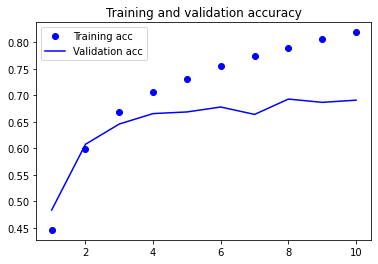

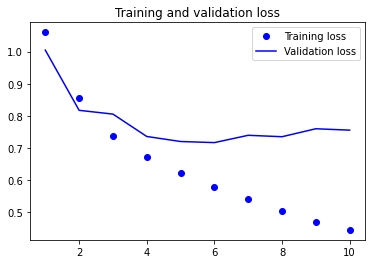

In [ ]:
plot_graphs(history)

In [ ]:
gru_model4.evaluate(x_test, y_test)

101/101 [==============================] - 39s 389ms/step - loss: 0.7400 - acc: 0.6831


[0.7399609088897705, 0.6831007599830627]

In [ ]:
pred=gru_model4.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 25s 238ms/step
              precision    recall  f1-score   support

         neg       0.66      0.70      0.68      1016
           n       0.61      0.65      0.63      1004
         pos       0.77      0.70      0.73      1205

    accuracy                           0.68      3225
   macro avg       0.68      0.68      0.68      3225
weighted avg       0.69      0.68      0.68      3225



In [ ]:
# definirea modelului ------------------128------------------
gru_model5 = Sequential()
gru_model5.add(embedding_layer)
gru_model5.add(GRU(128))
gru_model5.add(Dense(3, activation = 'softmax'))

gru_model5.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
history = gru_model5.fit(x_train,
                        y_train,
                        epochs=10,
                        batch_size=64,
                        validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 649s 4s/step - loss: 1.0427 - acc: 0.4659 - val_loss: 0.9517 - val_acc: 0.5499
Epoch 2/10
172/172 [==============================] - 643s 4s/step - loss: 0.7927 - acc: 0.6333 - val_loss: 0.7809 - val_acc: 0.6460
Epoch 3/10
172/172 [==============================] - 641s 4s/step - loss: 0.6879 - acc: 0.6927 - val_loss: 0.8683 - val_acc: 0.6016
Epoch 4/10
172/172 [==============================] - 643s 4s/step - loss: 0.6162 - acc: 0.7347 - val_loss: 0.7059 - val_acc: 0.6760
Epoch 5/10
172/172 [==============================] - 638s 4s/step - loss: 0.5514 - acc: 0.7676 - val_loss: 0.7014 - val_acc: 0.6915
Epoch 6/10
172/172 [==============================] - 639s 4s/step - loss: 0.4907 - acc: 0.7956 - val_loss: 0.7013 - val_acc: 0.6982
Epoch 7/10
172/172 [==============================] - 640s 4s/step - loss: 0.4305 - acc: 0.8260 - val_loss: 0.8604 - val_acc: 0.6527
Epoch 8/10
172/172 [==============================] - 641s 4s/step - 

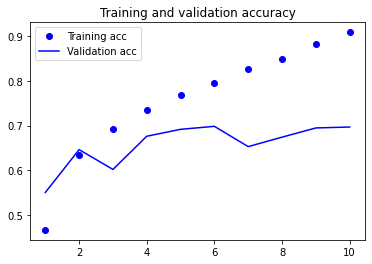

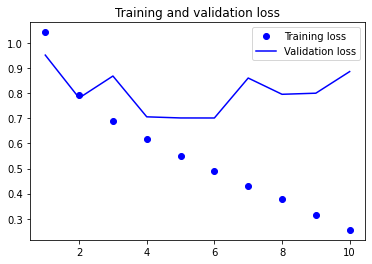

In [ ]:
plot_graphs(history)

In [ ]:
gru_model5.evaluate(x_test, y_test)

101/101 [==============================] - 44s 432ms/step - loss: 0.8993 - acc: 0.6794


[0.8992556929588318, 0.6793798208236694]

In [ ]:
pred=gru_model5.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 44s 431ms/step
              precision    recall  f1-score   support

         neg       0.75      0.64      0.69      1249
           n       0.51      0.72      0.60       752
         pos       0.77      0.70      0.73      1224

    accuracy                           0.68      3225
   macro avg       0.68      0.68      0.67      3225
weighted avg       0.70      0.68      0.68      3225



In [39]:
# definirea modelului ------------------256------------------
gru_model6 = Sequential()
gru_model6.add(embedding_layer)
gru_model6.add(CuDNNGRU(256))
gru_model6.add(Dense(3, activation = 'softmax'))

gru_model6.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
history = gru_model6.fit(x_train,
                        y_train,
                        epochs=10,
                        batch_size=64,
                        validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 25s 134ms/step - loss: 1.0312 - acc: 0.4742 - val_loss: 0.8390 - val_acc: 0.5969
Epoch 2/10
172/172 [==============================] - 22s 130ms/step - loss: 0.7615 - acc: 0.6524 - val_loss: 0.7812 - val_acc: 0.6444
Epoch 3/10
172/172 [==============================] - 23s 135ms/step - loss: 0.6561 - acc: 0.7113 - val_loss: 0.6861 - val_acc: 0.6868
Epoch 4/10
172/172 [==============================] - 23s 136ms/step - loss: 0.5629 - acc: 0.7564 - val_loss: 0.7634 - val_acc: 0.6775
Epoch 5/10
172/172 [==============================] - 24s 139ms/step - loss: 0.4758 - acc: 0.8055 - val_loss: 0.7073 - val_acc: 0.6930
Epoch 6/10
172/172 [==============================] - 24s 138ms/step - loss: 0.3849 - acc: 0.8451 - val_loss: 0.7635 - val_acc: 0.7168
Epoch 7/10
172/172 [==============================] - 25s 145ms/step - loss: 0.2813 - acc: 0.8959 - val_loss: 0.8687 - val_acc: 0.6827
Epoch 8/10
172/172 [==============================] - 2

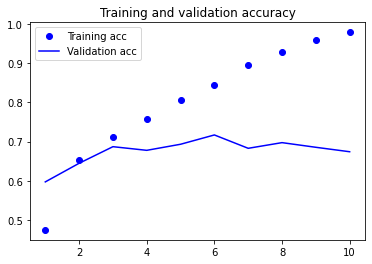

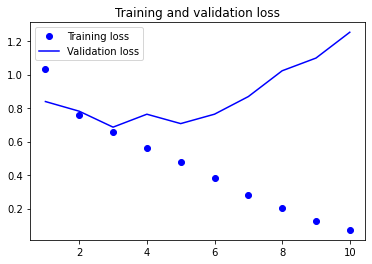

In [40]:
plot_graphs(history)

In [41]:
gru_model6.evaluate(x_test, y_test)

101/101 [==============================] - 5s 46ms/step - loss: 1.2446 - acc: 0.6750


[1.2445882558822632, 0.675038754940033]

In [42]:
pred=gru_model6.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 6s 54ms/step
              precision    recall  f1-score   support

         neg       0.60      0.76      0.67       845
           n       0.70      0.57      0.63      1289
         pos       0.72      0.73      0.73      1091

    accuracy                           0.68      3225
   macro avg       0.67      0.69      0.68      3225
weighted avg       0.68      0.68      0.67      3225



In [43]:
# definirea modelului ------------------512------------------
gru_model = Sequential()
gru_model.add(embedding_layer)
gru_model.add(CuDNNGRU(512))
gru_model.add(Dense(3, activation = 'softmax'))

gru_model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
history = gru_model.fit(x_train,
                        y_train,
                        epochs=10,
                        batch_size=64,
                        validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 74s 303ms/step - loss: 1.0313 - acc: 0.4958 - val_loss: 0.8291 - val_acc: 0.5933
Epoch 2/10
172/172 [==============================] - 54s 312ms/step - loss: 0.7600 - acc: 0.6565 - val_loss: 0.8113 - val_acc: 0.6434
Epoch 3/10
172/172 [==============================] - 55s 319ms/step - loss: 0.6386 - acc: 0.7209 - val_loss: 0.7249 - val_acc: 0.6770
Epoch 4/10
172/172 [==============================] - 56s 323ms/step - loss: 0.5125 - acc: 0.7816 - val_loss: 0.7431 - val_acc: 0.6925
Epoch 5/10
172/172 [==============================] - 56s 324ms/step - loss: 0.3775 - acc: 0.8483 - val_loss: 0.9375 - val_acc: 0.6207
Epoch 6/10
172/172 [==============================] - 56s 325ms/step - loss: 0.2305 - acc: 0.9155 - val_loss: 0.9292 - val_acc: 0.6651
Epoch 7/10
172/172 [==============================] - 58s 337ms/step - loss: 0.1120 - acc: 0.9643 - val_loss: 1.1659 - val_acc: 0.6651
Epoch 8/10
172/172 [==============================] - 5

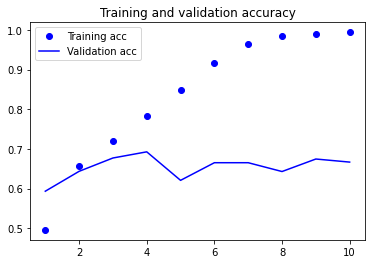

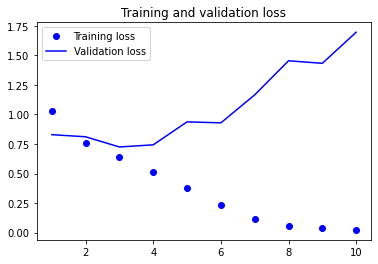

In [44]:
plot_graphs(history)

In [45]:
gru_model.evaluate(x_test, y_test)

101/101 [==============================] - 13s 116ms/step - loss: 1.6093 - acc: 0.6747


[1.6092725992202759, 0.6747286915779114]

In [46]:
pred=gru_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 10s 91ms/step
              precision    recall  f1-score   support

         neg       0.78      0.66      0.71      1257
           n       0.58      0.62      0.60       977
         pos       0.67      0.74      0.71       991

    accuracy                           0.67      3225
   macro avg       0.67      0.68      0.67      3225
weighted avg       0.68      0.67      0.68      3225



In [47]:
# ----128--0.2--64----0.2------
gru_model = Sequential()
gru_model.add(embedding_layer)
gru_model.add(CuDNNGRU(128,return_sequences = True))
gru_model.add(Dropout(0.2))
gru_model.add(CuDNNGRU(64))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(3, activation = 'softmax'))

gru_model.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = gru_model.fit(x_train, 
                         y_train,
                         epochs=10,
                         batch_size=64,
                         validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 39s 210ms/step - loss: 1.0159 - acc: 0.4789 - val_loss: 0.8593 - val_acc: 0.5628
Epoch 2/10
172/172 [==============================] - 32s 188ms/step - loss: 0.8032 - acc: 0.6225 - val_loss: 0.7824 - val_acc: 0.6537
Epoch 3/10
172/172 [==============================] - 29s 168ms/step - loss: 0.7125 - acc: 0.6808 - val_loss: 0.7348 - val_acc: 0.6693
Epoch 4/10
172/172 [==============================] - 30s 174ms/step - loss: 0.6468 - acc: 0.7170 - val_loss: 0.8056 - val_acc: 0.6718
Epoch 5/10
172/172 [==============================] - 28s 165ms/step - loss: 0.5863 - acc: 0.7457 - val_loss: 0.7069 - val_acc: 0.6827
Epoch 6/10
172/172 [==============================] - 29s 166ms/step - loss: 0.5324 - acc: 0.7740 - val_loss: 0.7248 - val_acc: 0.6982
Epoch 7/10
172/172 [==============================] - 29s 168ms/step - loss: 0.4818 - acc: 0.8024 - val_loss: 0.8686 - val_acc: 0.6475
Epoch 8/10
172/172 [==============================] - 2

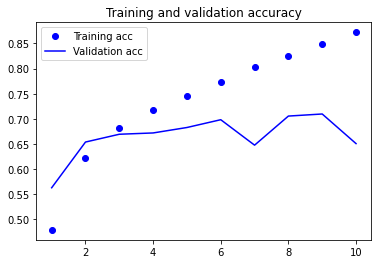

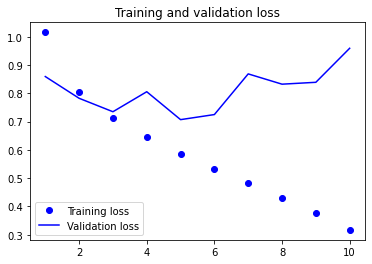

In [48]:
plot_graphs(history)

In [49]:
gru_model.evaluate(x_test, y_test)

101/101 [==============================] - 8s 68ms/step - loss: 0.9289 - acc: 0.6620


[0.9289185404777527, 0.6620154976844788]

In [50]:
pred=gru_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 9s 89ms/step
              precision    recall  f1-score   support

         neg       0.64      0.77      0.70       886
           n       0.75      0.54      0.62      1469
         pos       0.61      0.77      0.68       870

    accuracy                           0.66      3225
   macro avg       0.66      0.69      0.67      3225
weighted avg       0.68      0.66      0.66      3225



In [51]:
# ----128--0.4--64----0.4------
gru_model = Sequential()
gru_model.add(embedding_layer)
gru_model.add(CuDNNGRU(128,return_sequences = True))
gru_model.add(Dropout(0.4))
gru_model.add(CuDNNGRU(64))
gru_model.add(Dropout(0.4))
gru_model.add(Dense(3, activation = 'softmax'))

gru_model.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = gru_model.fit(x_train, 
                         y_train,
                         epochs=10,
                         batch_size=64,
                         validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 40s 221ms/step - loss: 1.0495 - acc: 0.4564 - val_loss: 0.8435 - val_acc: 0.5876
Epoch 2/10
172/172 [==============================] - 30s 175ms/step - loss: 0.8426 - acc: 0.6004 - val_loss: 0.8355 - val_acc: 0.6377
Epoch 3/10
172/172 [==============================] - 28s 166ms/step - loss: 0.7522 - acc: 0.6606 - val_loss: 0.7632 - val_acc: 0.6543
Epoch 4/10
172/172 [==============================] - 29s 167ms/step - loss: 0.6847 - acc: 0.7021 - val_loss: 0.7501 - val_acc: 0.6744
Epoch 5/10
172/172 [==============================] - 29s 167ms/step - loss: 0.6385 - acc: 0.7255 - val_loss: 0.6916 - val_acc: 0.6961
Epoch 6/10
172/172 [==============================] - 29s 166ms/step - loss: 0.5907 - acc: 0.7496 - val_loss: 0.6917 - val_acc: 0.7147
Epoch 7/10
172/172 [==============================] - 29s 166ms/step - loss: 0.5385 - acc: 0.7760 - val_loss: 0.9507 - val_acc: 0.6475
Epoch 8/10
172/172 [==============================] - 2

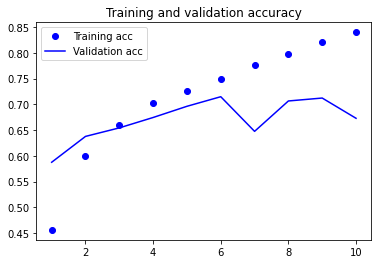

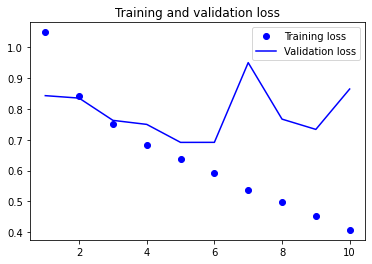

In [52]:
plot_graphs(history)

In [53]:
gru_model.evaluate(x_test, y_test)

101/101 [==============================] - 6s 62ms/step - loss: 0.8433 - acc: 0.6859


[0.8433265089988708, 0.6858914494514465]

In [54]:
pred=gru_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 6s 60ms/step
              precision    recall  f1-score   support

         neg       0.70      0.74      0.72      1013
           n       0.68      0.58      0.63      1230
         pos       0.67      0.75      0.71       982

    accuracy                           0.69      3225
   macro avg       0.69      0.69      0.69      3225
weighted avg       0.69      0.69      0.68      3225



In [56]:
# ----128--0.4--64--0.4--ADAM-0.0001-
gru_model = Sequential()
gru_model.add(embedding_layer)
gru_model.add(CuDNNGRU(128,return_sequences = True))
gru_model.add(Dropout(0.4))
gru_model.add(CuDNNGRU(64))
gru_model.add(Dropout(0.4))
gru_model.add(Dense(3, activation = 'softmax'))

gru_model.compile(optimizer= Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = gru_model.fit(x_train, 
                         y_train,
                         epochs=15,
                         batch_size=64,
                         validation_split=0.15)

Epoch 1/15
172/172 [==============================] - 30s 170ms/step - loss: 1.1470 - acc: 0.3672 - val_loss: 1.0690 - val_acc: 0.4233
Epoch 2/15
172/172 [==============================] - 29s 166ms/step - loss: 1.0922 - acc: 0.4139 - val_loss: 1.0472 - val_acc: 0.4470
Epoch 3/15
172/172 [==============================] - 29s 169ms/step - loss: 1.0673 - acc: 0.4423 - val_loss: 1.0352 - val_acc: 0.4656
Epoch 4/15
172/172 [==============================] - 28s 165ms/step - loss: 1.0474 - acc: 0.4584 - val_loss: 1.0242 - val_acc: 0.4713
Epoch 5/15
172/172 [==============================] - 29s 166ms/step - loss: 1.0356 - acc: 0.4719 - val_loss: 1.0159 - val_acc: 0.4956
Epoch 6/15
172/172 [==============================] - 28s 165ms/step - loss: 1.0135 - acc: 0.4910 - val_loss: 0.9973 - val_acc: 0.5003
Epoch 7/15
172/172 [==============================] - 30s 175ms/step - loss: 0.9844 - acc: 0.5146 - val_loss: 0.9715 - val_acc: 0.5168
Epoch 8/15
172/172 [==============================] - 2

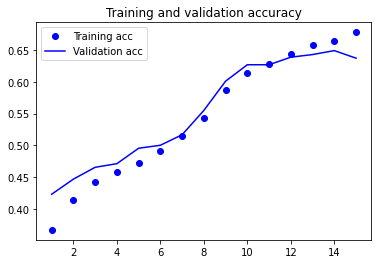

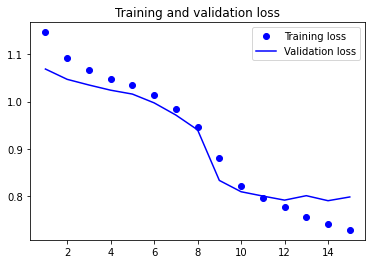

In [57]:
plot_graphs(history)

In [58]:
# ----128--0.4--64--0.4--ADAM-0.0001-
gru_model = Sequential()
gru_model.add(embedding_layer)
gru_model.add(CuDNNGRU(128,return_sequences = True))
gru_model.add(Dropout(0.4))
gru_model.add(CuDNNGRU(64))
gru_model.add(Dropout(0.4))
gru_model.add(Dense(3, activation = 'softmax'))

gru_model.compile(optimizer= Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = gru_model.fit(x_train, 
                         y_train,
                         epochs=30,
                         batch_size=64,
                         validation_split=0.15)

Epoch 1/30
172/172 [==============================] - 30s 168ms/step - loss: 1.1363 - acc: 0.3677 - val_loss: 1.0612 - val_acc: 0.4450
Epoch 2/30
172/172 [==============================] - 28s 164ms/step - loss: 1.0836 - acc: 0.4265 - val_loss: 1.0412 - val_acc: 0.4522
Epoch 3/30
172/172 [==============================] - 28s 165ms/step - loss: 1.0604 - acc: 0.4481 - val_loss: 1.0293 - val_acc: 0.4775
Epoch 4/30
172/172 [==============================] - 28s 165ms/step - loss: 1.0415 - acc: 0.4685 - val_loss: 1.0155 - val_acc: 0.4899
Epoch 5/30
172/172 [==============================] - 29s 166ms/step - loss: 1.0129 - acc: 0.4901 - val_loss: 0.9920 - val_acc: 0.5085
Epoch 6/30
172/172 [==============================] - 29s 169ms/step - loss: 0.9774 - acc: 0.5223 - val_loss: 0.9543 - val_acc: 0.5230
Epoch 7/30
172/172 [==============================] - 29s 170ms/step - loss: 0.9081 - acc: 0.5573 - val_loss: 0.8566 - val_acc: 0.6031
Epoch 8/30
172/172 [==============================] - 2

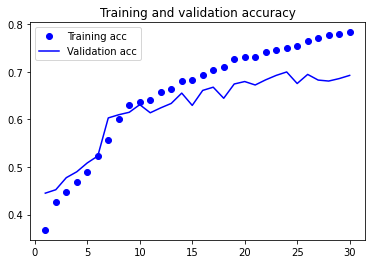

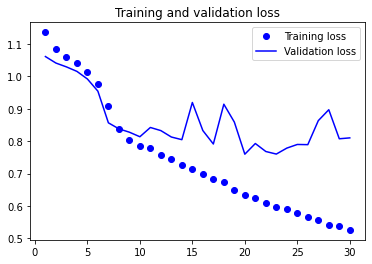

In [59]:
plot_graphs(history)

In [60]:
gru_model.evaluate(x_test, y_test)

101/101 [==============================] - 8s 83ms/step - loss: 0.7705 - acc: 0.7045


[0.7705212831497192, 0.7044961452484131]

In [61]:
pred=gru_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 7s 72ms/step
              precision    recall  f1-score   support

         neg       0.77      0.68      0.72      1207
           n       0.59      0.70      0.64       899
         pos       0.75      0.74      0.74      1119

    accuracy                           0.70      3225
   macro avg       0.70      0.70      0.70      3225
weighted avg       0.71      0.70      0.71      3225



In [62]:
# ----128--0.4--64--0.4--ADAM -0.001-
gru_model = Sequential()
gru_model.add(embedding_layer)
gru_model.add(CuDNNGRU(128,return_sequences = True))
gru_model.add(Dropout(0.4))
gru_model.add(CuDNNGRU(64))
gru_model.add(Dropout(0.4))
gru_model.add(Dense(3, activation = 'softmax'))

gru_model.compile(optimizer= Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = gru_model.fit(x_train, 
                         y_train,
                         epochs=15,
                         batch_size=64,
                         validation_split=0.15)

Epoch 1/15
172/172 [==============================] - 35s 197ms/step - loss: 1.0625 - acc: 0.4524 - val_loss: 0.8741 - val_acc: 0.5783
Epoch 2/15
172/172 [==============================] - 29s 169ms/step - loss: 0.8175 - acc: 0.6173 - val_loss: 0.7500 - val_acc: 0.6543
Epoch 3/15
172/172 [==============================] - 28s 165ms/step - loss: 0.7098 - acc: 0.6890 - val_loss: 0.7099 - val_acc: 0.6853
Epoch 4/15
172/172 [==============================] - 29s 166ms/step - loss: 0.6449 - acc: 0.7239 - val_loss: 0.6812 - val_acc: 0.6961
Epoch 5/15
172/172 [==============================] - 31s 178ms/step - loss: 0.5743 - acc: 0.7578 - val_loss: 0.6610 - val_acc: 0.7163
Epoch 6/15
172/172 [==============================] - 29s 168ms/step - loss: 0.5355 - acc: 0.7783 - val_loss: 0.6942 - val_acc: 0.7142
Epoch 7/15
172/172 [==============================] - 30s 172ms/step - loss: 0.4692 - acc: 0.8048 - val_loss: 0.7174 - val_acc: 0.7127
Epoch 8/15
172/172 [==============================] - 2

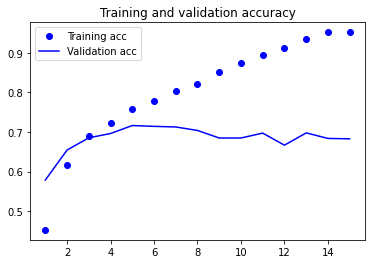

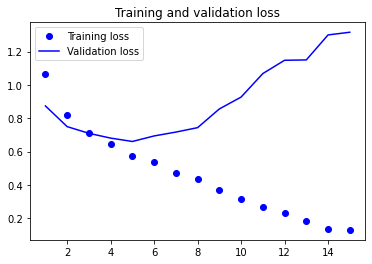

In [63]:
plot_graphs(history)

In [64]:
gru_model.evaluate(x_test, y_test)

101/101 [==============================] - 6s 60ms/step - loss: 1.2929 - acc: 0.6899


[1.292861819267273, 0.6899224519729614]

In [65]:
pred=gru_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 6s 59ms/step
              precision    recall  f1-score   support

         neg       0.60      0.80      0.69       808
           n       0.74      0.57      0.64      1370
         pos       0.73      0.77      0.75      1047

    accuracy                           0.69      3225
   macro avg       0.69      0.71      0.69      3225
weighted avg       0.70      0.69      0.69      3225



### Convnet 1D

In [ ]:
# definirea modelului---------8------------------
convnet_model = Sequential()
convnet_model.add(embedding_layer)
convnet_model.add(Conv1D(8, 7, activation='relu'))
convnet_model.add(MaxPooling1D(5))
convnet_model.add(Conv1D(8, 7, activation='relu'))
convnet_model.add(GlobalMaxPooling1D())
convnet_model.add(Dense(3, activation='softmax'))

convnet_model.compile(optimizer=RMSprop(learning_rate=1e-4), 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])
history = convnet_model.fit(x_train, 
                            y_train,
                            epochs=10,
                            batch_size=64,
                            validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 77s 444ms/step - loss: 1.8620 - acc: 0.3317 - val_loss: 1.1766 - val_acc: 0.3390
Epoch 2/10
172/172 [==============================] - 76s 442ms/step - loss: 1.1307 - acc: 0.3660 - val_loss: 1.0965 - val_acc: 0.4078
Epoch 3/10
172/172 [==============================] - 76s 440ms/step - loss: 1.0748 - acc: 0.4412 - val_loss: 1.0560 - val_acc: 0.4811
Epoch 4/10
172/172 [==============================] - 77s 447ms/step - loss: 1.0438 - acc: 0.4964 - val_loss: 1.0321 - val_acc: 0.5256
Epoch 5/10
172/172 [==============================] - 77s 448ms/step - loss: 1.0210 - acc: 0.5296 - val_loss: 1.0170 - val_acc: 0.5426
Epoch 6/10
172/172 [==============================] - 76s 440ms/step - loss: 1.0012 - acc: 0.5497 - val_loss: 1.0016 - val_acc: 0.5587
Epoch 7/10
172/172 [==============================] - 75s 438ms/step - loss: 0.9830 - acc: 0.5648 - val_loss: 0.9905 - val_acc: 0.5649
Epoch 8/10
172/172 [==============================] - 7

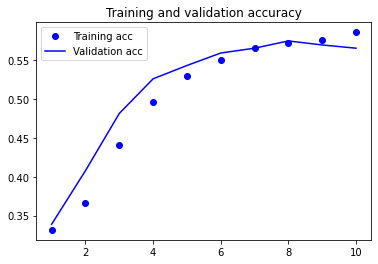

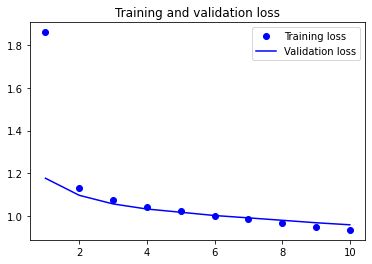

In [ ]:
plot_graphs(history)

In [ ]:
convnet_model.evaluate(x_test, y_test)

101/101 [==============================] - 5s 49ms/step - loss: 0.9658 - acc: 0.5662


[0.9658004641532898, 0.5662015676498413]

In [ ]:
pred=convnet_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 5s 49ms/step
              precision    recall  f1-score   support

         neg       0.49      0.54      0.51       982
           n       0.44      0.61      0.51       747
         pos       0.76      0.56      0.65      1496

    accuracy                           0.57      3225
   macro avg       0.56      0.57      0.56      3225
weighted avg       0.60      0.57      0.57      3225



In [ ]:
# definirea modelului---------16------------------
convnet_model = Sequential()
convnet_model.add(embedding_layer)
convnet_model.add(Conv1D(16, 7, activation='relu'))
convnet_model.add(MaxPooling1D(5))
convnet_model.add(Conv1D(16, 7, activation='relu'))
convnet_model.add(GlobalMaxPooling1D())
convnet_model.add(Dense(3, activation='softmax'))

convnet_model.compile(optimizer=RMSprop(learning_rate=1e-4), 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])
history = convnet_model.fit(x_train, 
                            y_train,
                            epochs=10,
                            batch_size=64,
                            validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 83s 480ms/step - loss: 1.4749 - acc: 0.3316 - val_loss: 1.2415 - val_acc: 0.4047
Epoch 2/10
172/172 [==============================] - 87s 504ms/step - loss: 1.1276 - acc: 0.4527 - val_loss: 1.1192 - val_acc: 0.4946
Epoch 3/10
172/172 [==============================] - 90s 525ms/step - loss: 1.0325 - acc: 0.5069 - val_loss: 1.0713 - val_acc: 0.5018
Epoch 4/10
172/172 [==============================] - 85s 496ms/step - loss: 0.9735 - acc: 0.5376 - val_loss: 1.0455 - val_acc: 0.5251
Epoch 5/10
172/172 [==============================] - 85s 495ms/step - loss: 0.9279 - acc: 0.5659 - val_loss: 1.0231 - val_acc: 0.5359
Epoch 6/10
172/172 [==============================] - 83s 482ms/step - loss: 0.8917 - acc: 0.5884 - val_loss: 1.0072 - val_acc: 0.5318
Epoch 7/10
172/172 [==============================] - 83s 486ms/step - loss: 0.8620 - acc: 0.6029 - val_loss: 1.0029 - val_acc: 0.5375
Epoch 8/10
172/172 [==============================] - 8

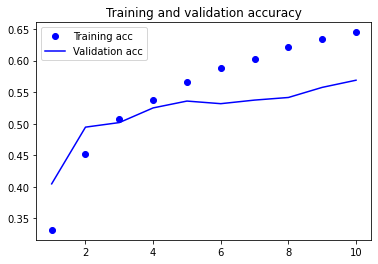

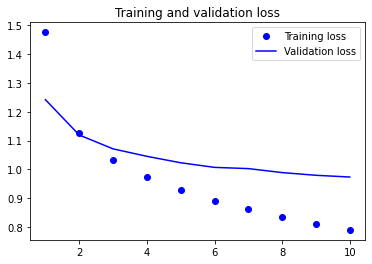

In [ ]:
plot_graphs(history)

In [ ]:
convnet_model.evaluate(x_test, y_test)

101/101 [==============================] - 6s 59ms/step - loss: 0.9606 - acc: 0.5727


[0.9606403112411499, 0.5727131962776184]

In [ ]:
pred=convnet_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 6s 59ms/step
              precision    recall  f1-score   support

         neg       0.41      0.58      0.48       744
           n       0.51      0.59      0.55       916
         pos       0.79      0.56      0.66      1565

    accuracy                           0.57      3225
   macro avg       0.57      0.58      0.56      3225
weighted avg       0.62      0.57      0.58      3225



In [ ]:
# definirea modelului---------32------------------
convnet_model = Sequential()
convnet_model.add(embedding_layer)
convnet_model.add(Conv1D(32, 7, activation='relu'))
convnet_model.add(MaxPooling1D(5))
convnet_model.add(Conv1D(32, 7, activation='relu'))
convnet_model.add(GlobalMaxPooling1D())
convnet_model.add(Dense(3, activation='softmax'))

convnet_model.compile(optimizer=RMSprop(learning_rate=1e-4), 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])
history = convnet_model.fit(x_train, 
                            y_train,
                            epochs=10,
                            batch_size=64,
                            validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 106s 610ms/step - loss: 1.1255 - acc: 0.4551 - val_loss: 0.9807 - val_acc: 0.5385
Epoch 2/10
172/172 [==============================] - 103s 600ms/step - loss: 0.9558 - acc: 0.5409 - val_loss: 0.9329 - val_acc: 0.5442
Epoch 3/10
172/172 [==============================] - 102s 596ms/step - loss: 0.8825 - acc: 0.5807 - val_loss: 0.9301 - val_acc: 0.5855
Epoch 4/10
172/172 [==============================] - 103s 601ms/step - loss: 0.8328 - acc: 0.6066 - val_loss: 0.8978 - val_acc: 0.5809
Epoch 5/10
172/172 [==============================] - 103s 601ms/step - loss: 0.7886 - acc: 0.6359 - val_loss: 0.8814 - val_acc: 0.5886
Epoch 6/10
172/172 [==============================] - 106s 616ms/step - loss: 0.7540 - acc: 0.6575 - val_loss: 0.8756 - val_acc: 0.5850
Epoch 7/10
172/172 [==============================] - 105s 608ms/step - loss: 0.7241 - acc: 0.6779 - val_loss: 0.8726 - val_acc: 0.5876
Epoch 8/10
172/172 [============================

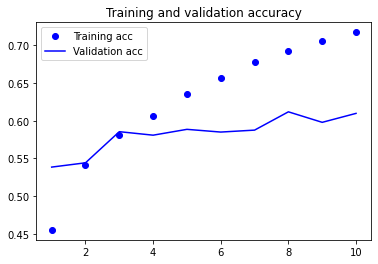

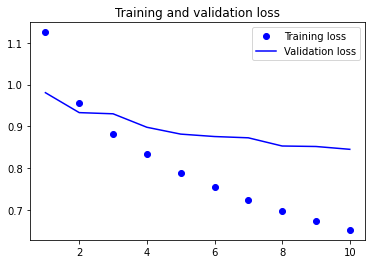

In [ ]:
plot_graphs(history)

In [ ]:
convnet_model.evaluate(x_test, y_test)

101/101 [==============================] - 9s 85ms/step - loss: 0.8678 - acc: 0.5975


[0.8678054809570312, 0.5975193977355957]

In [ ]:
pred=convnet_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 9s 84ms/step
              precision    recall  f1-score   support

         neg       0.55      0.59      0.57       998
           n       0.54      0.59      0.57       971
         pos       0.70      0.61      0.65      1256

    accuracy                           0.60      3225
   macro avg       0.60      0.60      0.59      3225
weighted avg       0.60      0.60      0.60      3225



In [ ]:
# definirea modelului---------64------------------
convnet_model = Sequential()
convnet_model.add(embedding_layer)
convnet_model.add(Conv1D(64, 7, activation='relu'))
convnet_model.add(MaxPooling1D(5))
convnet_model.add(Conv1D(64, 7, activation='relu'))
convnet_model.add(GlobalMaxPooling1D())
convnet_model.add(Dense(3, activation='softmax'))

convnet_model.compile(optimizer=RMSprop(learning_rate=1e-4), 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])
history = convnet_model.fit(x_train, 
                            y_train,
                            epochs=10,
                            batch_size=64,
                            validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 159s 917ms/step - loss: 1.1692 - acc: 0.4994 - val_loss: 0.9974 - val_acc: 0.5628
Epoch 2/10
172/172 [==============================] - 157s 914ms/step - loss: 0.9136 - acc: 0.5765 - val_loss: 0.9428 - val_acc: 0.5829
Epoch 3/10
172/172 [==============================] - 156s 908ms/step - loss: 0.8134 - acc: 0.6285 - val_loss: 1.0545 - val_acc: 0.5054
Epoch 4/10
172/172 [==============================] - 157s 914ms/step - loss: 0.7370 - acc: 0.6702 - val_loss: 0.9308 - val_acc: 0.5907
Epoch 5/10
172/172 [==============================] - 160s 932ms/step - loss: 0.6789 - acc: 0.6991 - val_loss: 0.9094 - val_acc: 0.5850
Epoch 6/10
172/172 [==============================] - 159s 924ms/step - loss: 0.6277 - acc: 0.7328 - val_loss: 0.9520 - val_acc: 0.6258
Epoch 7/10
172/172 [==============================] - 158s 916ms/step - loss: 0.5867 - acc: 0.7532 - val_loss: 0.8995 - val_acc: 0.5990
Epoch 8/10
172/172 [============================

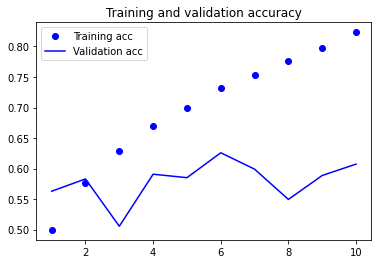

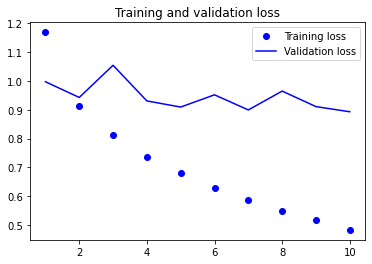

In [ ]:
plot_graphs(history)

In [ ]:
convnet_model.evaluate(x_test,y_test)

101/101 [==============================] - 15s 145ms/step - loss: 0.8826 - acc: 0.6096


[0.882637619972229, 0.6096124053001404]

In [ ]:
pred=convnet_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 15s 143ms/step
              precision    recall  f1-score   support

         neg       0.55      0.59      0.57       994
           n       0.56      0.61      0.58       967
         pos       0.72      0.63      0.67      1264

    accuracy                           0.61      3225
   macro avg       0.61      0.61      0.61      3225
weighted avg       0.62      0.61      0.61      3225



In [66]:
# definirea modelului---------128------------------
convnet_model = Sequential()
convnet_model.add(embedding_layer)
convnet_model.add(Conv1D(128, 7, activation='relu'))
convnet_model.add(MaxPooling1D(5))
convnet_model.add(Conv1D(128, 7, activation='relu'))
convnet_model.add(GlobalMaxPooling1D())
convnet_model.add(Dense(3, activation='softmax'))

convnet_model.compile(optimizer=RMSprop(learning_rate=1e-4), 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])
history = convnet_model.fit(x_train, 
                            y_train,
                            epochs=10,
                            batch_size=64,
                            validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 10s 31ms/step - loss: 1.1409 - acc: 0.4957 - val_loss: 0.9527 - val_acc: 0.5519
Epoch 2/10
172/172 [==============================] - 5s 28ms/step - loss: 0.8818 - acc: 0.6032 - val_loss: 1.2163 - val_acc: 0.4424
Epoch 3/10
172/172 [==============================] - 5s 30ms/step - loss: 0.7584 - acc: 0.6589 - val_loss: 0.9166 - val_acc: 0.5912
Epoch 4/10
172/172 [==============================] - 5s 28ms/step - loss: 0.6785 - acc: 0.7000 - val_loss: 0.9939 - val_acc: 0.5137
Epoch 5/10
172/172 [==============================] - 5s 30ms/step - loss: 0.6074 - acc: 0.7406 - val_loss: 1.0364 - val_acc: 0.5018
Epoch 6/10
172/172 [==============================] - 5s 28ms/step - loss: 0.5554 - acc: 0.7715 - val_loss: 0.9178 - val_acc: 0.5643
Epoch 7/10
172/172 [==============================] - 5s 28ms/step - loss: 0.5028 - acc: 0.8053 - val_loss: 0.9510 - val_acc: 0.5628
Epoch 8/10
172/172 [==============================] - 5s 30ms/step -

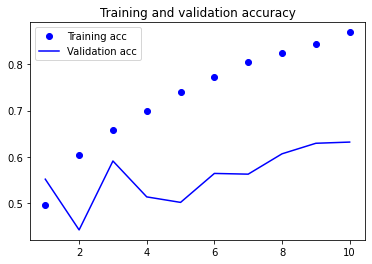

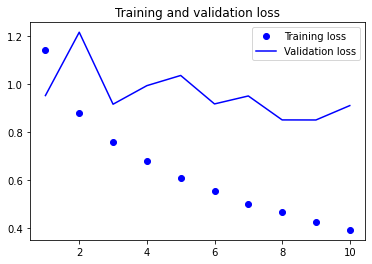

In [67]:
plot_graphs(history)

In [68]:
convnet_model.evaluate(x_test,y_test)

101/101 [==============================] - 1s 8ms/step - loss: 0.8805 - acc: 0.6509


[0.8804869055747986, 0.6508527398109436]

In [69]:
pred=convnet_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

         neg       0.49      0.73      0.59       723
           n       0.50      0.71      0.59       742
         pos       0.95      0.59      0.73      1760

    accuracy                           0.65      3225
   macro avg       0.65      0.68      0.64      3225
weighted avg       0.74      0.65      0.67      3225



In [70]:
# definirea modelului---------256------------------
convnet_model = Sequential()
convnet_model.add(embedding_layer)
convnet_model.add(Conv1D(256, 7, activation='relu'))
convnet_model.add(MaxPooling1D(5))
convnet_model.add(Conv1D(256, 7, activation='relu'))
convnet_model.add(GlobalMaxPooling1D())
convnet_model.add(Dense(3, activation='softmax'))

convnet_model.compile(optimizer=RMSprop(learning_rate=1e-4), 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])
history = convnet_model.fit(x_train, 
                            y_train,
                            epochs=10,
                            batch_size=64,
                            validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 10s 54ms/step - loss: 1.2755 - acc: 0.4872 - val_loss: 0.9282 - val_acc: 0.5302
Epoch 2/10
172/172 [==============================] - 9s 52ms/step - loss: 0.8939 - acc: 0.6005 - val_loss: 0.9989 - val_acc: 0.6129
Epoch 3/10
172/172 [==============================] - 9s 52ms/step - loss: 0.7637 - acc: 0.6598 - val_loss: 0.9484 - val_acc: 0.6109
Epoch 4/10
172/172 [==============================] - 9s 52ms/step - loss: 0.6638 - acc: 0.7151 - val_loss: 0.9606 - val_acc: 0.5804
Epoch 5/10
172/172 [==============================] - 9s 52ms/step - loss: 0.5859 - acc: 0.7570 - val_loss: 0.8462 - val_acc: 0.6537
Epoch 6/10
172/172 [==============================] - 9s 53ms/step - loss: 0.5221 - acc: 0.7931 - val_loss: 0.7917 - val_acc: 0.6284
Epoch 7/10
172/172 [==============================] - 9s 53ms/step - loss: 0.4667 - acc: 0.8240 - val_loss: 0.8270 - val_acc: 0.6062
Epoch 8/10
172/172 [==============================] - 9s 53ms/step -

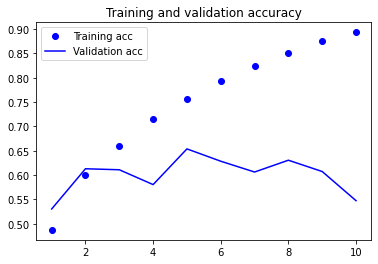

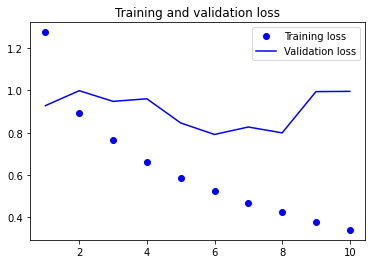

In [71]:
plot_graphs(history)

In [72]:
# definirea modelului---------512------------------
convnet_model = Sequential()
convnet_model.add(embedding_layer)
convnet_model.add(Conv1D(512, 7, activation='relu'))
convnet_model.add(MaxPooling1D(5))
convnet_model.add(Conv1D(512, 7, activation='relu'))
convnet_model.add(GlobalMaxPooling1D())
convnet_model.add(Dense(3, activation='softmax'))

convnet_model.compile(optimizer=RMSprop(learning_rate=1e-4), 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])
history = convnet_model.fit(x_train, 
                            y_train,
                            epochs=10,
                            batch_size=64,
                            validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 22s 122ms/step - loss: 1.5357 - acc: 0.4927 - val_loss: 1.1883 - val_acc: 0.4486
Epoch 2/10
172/172 [==============================] - 21s 120ms/step - loss: 0.9043 - acc: 0.6029 - val_loss: 1.2898 - val_acc: 0.5943
Epoch 3/10
172/172 [==============================] - 21s 121ms/step - loss: 0.7471 - acc: 0.6713 - val_loss: 0.9183 - val_acc: 0.6305
Epoch 4/10
172/172 [==============================] - 21s 121ms/step - loss: 0.6370 - acc: 0.7256 - val_loss: 0.9358 - val_acc: 0.5090
Epoch 5/10
172/172 [==============================] - 21s 122ms/step - loss: 0.5406 - acc: 0.7762 - val_loss: 1.1387 - val_acc: 0.4310
Epoch 6/10
172/172 [==============================] - 21s 123ms/step - loss: 0.4630 - acc: 0.8282 - val_loss: 0.7675 - val_acc: 0.6625
Epoch 7/10
172/172 [==============================] - 21s 123ms/step - loss: 0.4023 - acc: 0.8581 - val_loss: 0.9450 - val_acc: 0.6450
Epoch 8/10
172/172 [==============================] - 2

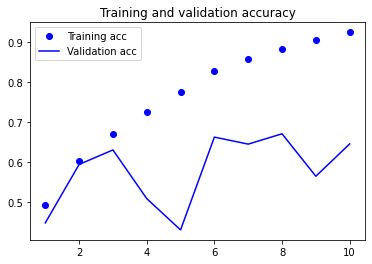

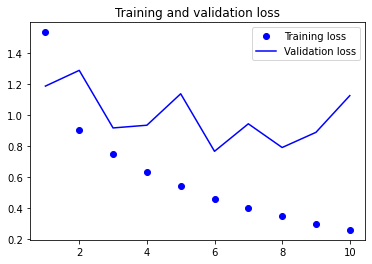

In [73]:
plot_graphs(history)

In [74]:
convnet_model.evaluate(x_test, y_test)

101/101 [==============================] - 3s 25ms/step - loss: 1.1347 - acc: 0.6384


[1.134718894958496, 0.6384496092796326]

In [75]:
pred=convnet_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 2s 22ms/step
              precision    recall  f1-score   support

         neg       0.39      0.81      0.52       512
           n       0.52      0.76      0.62       730
         pos       0.99      0.55      0.71      1983

    accuracy                           0.64      3225
   macro avg       0.63      0.71      0.62      3225
weighted avg       0.79      0.64      0.66      3225



In [76]:
# definirea modelului---------512------------------
convnet_model = Sequential()
convnet_model.add(embedding_layer)
convnet_model.add(Conv1D(512, 7, activation='relu'))
convnet_model.add(MaxPooling1D(5))
convnet_model.add(Conv1D(128, 7, activation='relu'))
convnet_model.add(GlobalMaxPooling1D())
convnet_model.add(Dense(3, activation='softmax'))

convnet_model.compile(optimizer=RMSprop(learning_rate=1e-4), 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])
history = convnet_model.fit(x_train, 
                            y_train,
                            epochs=10,
                            batch_size=64,
                            validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 17s 91ms/step - loss: 1.1542 - acc: 0.5181 - val_loss: 0.9074 - val_acc: 0.5416
Epoch 2/10
172/172 [==============================] - 15s 87ms/step - loss: 0.8358 - acc: 0.6244 - val_loss: 1.0535 - val_acc: 0.4372
Epoch 3/10
172/172 [==============================] - 15s 85ms/step - loss: 0.6965 - acc: 0.6953 - val_loss: 1.0646 - val_acc: 0.4817
Epoch 4/10
172/172 [==============================] - 15s 85ms/step - loss: 0.6005 - acc: 0.7534 - val_loss: 1.2572 - val_acc: 0.5891
Epoch 5/10
172/172 [==============================] - 15s 86ms/step - loss: 0.5263 - acc: 0.7911 - val_loss: 0.7980 - val_acc: 0.6186
Epoch 6/10
172/172 [==============================] - 15s 86ms/step - loss: 0.4624 - acc: 0.8268 - val_loss: 0.8230 - val_acc: 0.6486
Epoch 7/10
172/172 [==============================] - 15s 86ms/step - loss: 0.4034 - acc: 0.8641 - val_loss: 0.8234 - val_acc: 0.6491
Epoch 8/10
172/172 [==============================] - 15s 87ms

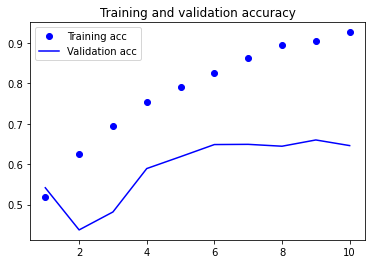

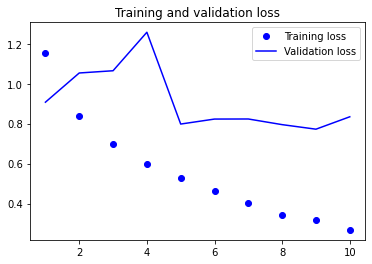

In [77]:
plot_graphs(history)

In [78]:
convnet_model.evaluate(x_test, y_test)

101/101 [==============================] - 2s 19ms/step - loss: 0.8286 - acc: 0.6416


[0.8286437392234802, 0.6415503621101379]

In [79]:
pred=convnet_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 2s 16ms/step
              precision    recall  f1-score   support

         neg       0.80      0.54      0.65      1581
           n       0.44      0.80      0.57       585
         pos       0.67      0.70      0.69      1059

    accuracy                           0.64      3225
   macro avg       0.64      0.68      0.64      3225
weighted avg       0.70      0.64      0.65      3225



In [87]:
# definirea modelului---------512---128----128----l2(0.01)-------
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(512, 7, kernel_regularizer=l2(0.001), activation='relu'))
model.add(MaxPooling1D(5))
model.add(CuDNNLSTM(128, return_sequences=True))
model.add(Dropout(0.4))
model.add(CuDNNLSTM(64))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])
history = model.fit(x_train, 
                    y_train,
                    epochs=20,
                    batch_size=64,
                    validation_split=0.15)

Epoch 1/20
172/172 [==============================] - 21s 115ms/step - loss: 1.1078 - acc: 0.5497 - val_loss: 0.9923 - val_acc: 0.6165
Epoch 2/20
172/172 [==============================] - 20s 115ms/step - loss: 0.9828 - acc: 0.6287 - val_loss: 0.9482 - val_acc: 0.6481
Epoch 3/20
172/172 [==============================] - 20s 117ms/step - loss: 0.9308 - acc: 0.6551 - val_loss: 0.9133 - val_acc: 0.6656
Epoch 4/20
172/172 [==============================] - 20s 115ms/step - loss: 0.8876 - acc: 0.6769 - val_loss: 0.8876 - val_acc: 0.6724
Epoch 5/20
172/172 [==============================] - 20s 114ms/step - loss: 0.8319 - acc: 0.7073 - val_loss: 0.8899 - val_acc: 0.6858
Epoch 6/20
172/172 [==============================] - 20s 115ms/step - loss: 0.7741 - acc: 0.7385 - val_loss: 0.8721 - val_acc: 0.6873
Epoch 7/20
172/172 [==============================] - 20s 115ms/step - loss: 0.7028 - acc: 0.7674 - val_loss: 0.8877 - val_acc: 0.6904
Epoch 8/20
172/172 [==============================] - 2

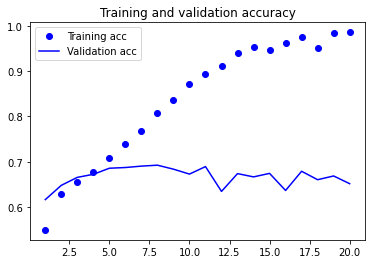

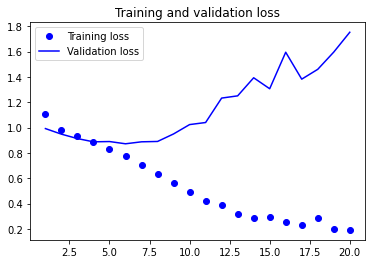

In [88]:
plot_graphs(history)

In [85]:
model.evaluate(x_test, y_test)

101/101 [==============================] - 3s 31ms/step - loss: 1.2313 - acc: 0.6657


[1.2313220500946045, 0.6657364368438721]

In [ ]:
pred=convnet_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))